# Comparison of SVERAD and SHAP on the RBF kernel for 50 random compounds.

In [1]:
from src.sverad import compute_sverad_sv, rbf_kernel_matrix, ExactRBFShapleyComputation, rbf_kernel
from src.utils import set_seeds, DataSet, UnfoldedMorganFingerprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from scipy.stats import pearsonr
from tqdm.auto import tqdm
import warnings
import os
import shap

In [2]:
SEED = 42
set_seeds(SEED)
GAMMA = 1.0

SAVE_DATASET_PICKLE = False
LOAD_PRECOMPUTED_EXPLANATIONS = False
SAVE_EXPLANATIONS = True
SAMPLE_SIZE = 10

### Load and generate dataset

In [3]:
dataset_df = pd.read_csv("data/dataset.tsv", sep="\t")
dataset_df.pivot_table(index="uniprot_id", columns="label", values="nonstereo_aromatic_smiles", aggfunc="nunique", fill_value=0)

label,active,random
uniprot_id,,
P0DMS8,287,287


In [4]:
dataset_dict = dict()
fingerprint_gen_dict = dict()
for dataset_name, data_grpd_df in dataset_df.groupby("uniprot_id"):
    
    # label: 1: active, 0: random
    labels = np.array([1 if l == 'active' else 0 for l in data_grpd_df.label])
    # Creating Fingerprint
    morgan_radius2 = UnfoldedMorganFingerprint(radius=2)
    morgan_radius2.fit_smiles(data_grpd_df.nonstereo_aromatic_smiles.tolist())
    
    # Constructing Dataset
    fp_matrix = morgan_radius2.transform_smiles(data_grpd_df.nonstereo_aromatic_smiles.tolist())
    # Constructing Dataset
    dataset = DataSet(labels, fp_matrix)
    dataset.add_attribute("nonstereo_aromatic_smiles", data_grpd_df.nonstereo_aromatic_smiles.values)
    
    dataset_dict[dataset_name] = dataset
    fingerprint_gen_dict[dataset_name] = morgan_radius2

#### Save dataset and fingerprint for future use

In [5]:
if SAVE_DATASET_PICKLE:
    with open("./data/pickle/dataset_dict.p", "wb") as outfile:
        pickle.dump(dataset_dict, outfile)
    with open("./data/pickle/fingerprint_gen_dict.p", "wb") as outfile:
        pickle.dump(fingerprint_gen_dict, outfile)

# Analysis

In [6]:
dataset = dataset_dict["P0DMS8"]

In [7]:
print("Number of CPDs: {}\nNumber of features: {}".format(*dataset.feature_matrix.shape))

Number of CPDs: 574
Number of features: 5487


In [8]:
save_path = "./data/pickle/explanations_50_cpd_rbf_SVERAD_SHAP.p"
if not LOAD_PRECOMPUTED_EXPLANATIONS: # This takes about 8h
    explanation_df = []
    # Selecting a random subset
    subset = shap.sample(dataset.feature_matrix, nsamples=SAMPLE_SIZE,  random_state=SEED)

    # Iterating over all pairs.
    for i, arr_i in tqdm(enumerate(subset), total=subset.shape[0]):
        
        print(np.array(arr_i.toarray()[0]))
        
        sim_func = lambda x: rbf_kernel(np.array(x.toarray()[0]), np.array(arr_i.toarray()[0]), gamma = GAMMA)
        # exact_shapley_gen_i = ExactRBFShapleyComputation(arr_i, gamma=GAMMA) #used only to compute RBF kernel value
        for j, arr_j in tqdm(enumerate(subset), total=subset.shape[0]):
            if i == j:
                continue
            
            # intersection_ij = arr_i.toarray()[0] * arr_j.toarray()[0]
            # union_ij = 1 - (1-arr_i.toarray()[0]) * (1-arr_j.toarray()[0])
            # diff_ij = union_ij - intersection_ij
            # sveta_values_ij = intersection_ij * sveta_f_plus(sum(intersection_ij), sum(diff_ij))
            # sveta_values_ij += diff_ij * sveta_f_minus(sum(intersection_ij), sum(diff_ij))

            sverad_values_ij = compute_sverad_sv(arr_i.toarray()[0], arr_j.toarray()[0], gamma=GAMMA)
            # removing CPDs of the pair from the background sample.
            mask = np.ones(subset.shape[0], dtype=bool)
            mask[i] = False
            mask[j] = False
            available_as_sample = subset[mask]
            with warnings.catch_warnings():
                # ignore all caught warnings
                warnings.filterwarnings("ignore")
                explainer_vi = shap.KernelExplainer(sim_func(arr_i), available_as_sample)
                # explainer_vi = shap.KernelExplainer(exact_shapley_gen_i.rbf_kernel_value, available_as_sample)
                shap_ij = explainer_vi.shap_values(arr_j, silent=True)
            explanation_df.append({"instance a": i,
                                   "instance b": j,
                                   "SVERAD": sverad_values_ij,
                                   "SHAP": shap_ij,
                                   "SHAP_expected_value": explainer_vi.expected_value,
                                   })
        break
    explanation_df = pd.DataFrame(explanation_df)
    if SAVE_EXPLANATIONS:
        with open(save_path, "wb") as outfile:
            pickle.dump(explanation_df, outfile)
else:
    with open(save_path, "rb") as infile:
        explanation_df = pickle.load(infile)

  0%|          | 0/10 [00:00<?, ?it/s]

[1 1 1 ... 0 0 0]


  0%|          | 0/10 [00:00<?, ?it/s]

Provided model function fails when applied to the provided data set.


TypeError: 'numpy.float64' object is not callable

In [ ]:
explanation_df.loc[0]["SHAP"]

KeyError: 0

### Correlation

In [ ]:
corr_df = []
for i, row in explanation_df.iterrows():
    if row["instance a"] == row["instance b"]:
        continue
    sverad_value = row["SVERAD"]
    shap = row["SHAP"][0]
    
    
    corr_sverad_SHAP, p_sverad_SHAP = pearsonr(sverad_value, shap)
    

    corr_df.append({"a": row["instance a"], "b": row["instance b"],  "Correlation SVERAD - SHAP": corr_sverad_SHAP})
corr_df = pd.DataFrame(corr_df)
display(corr_df)
display(corr_df.mean())
display(corr_df.std())

An input array is constant; the correlation coefficient is not defined.


,a,b,Correlation SVERAD - SHAP
0,0,1,NaN
1,0,2,NaN
2,0,3,NaN
3,0,4,NaN
4,0,5,NaN
5,0,6,NaN
6,0,7,NaN
7,0,8,NaN
8,0,9,NaN


a                            0.0
b                            5.0
Correlation SVERAD - SHAP    NaN
dtype: float64

a                            0.000000
b                            2.738613
Correlation SVERAD - SHAP         NaN
dtype: float64

In [ ]:
corr_df = []
for i, row in explanation_df.iterrows():
    if row["instance a"] == row["instance b"]:
        continue
    sveata_values = row["SVETA"]
    kernel_shap = row["SHAP"][0]
    
    corr, p = pearsonr(sveata_values, kernel_shap)
    corr_df.append({"a": row["instance a"], "b": row["instance b"], "correlation": corr})
corr_df = pd.DataFrame(corr_df)
# Fisher transformation
corr_df["pearsons_r_fisher"] = np.arctanh(corr_df.correlation)

KeyError: 'SVETA'

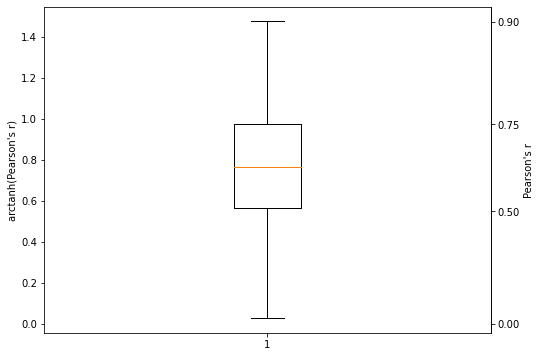

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot(corr_df.pearsons_r_fisher)
#ax.set_ylim(-0.1,4.05)
ax.set_ylabel("arctanh(Pearson's r)")
secax = ax.secondary_yaxis('right', functions=(np.tanh, np.arctanh))
secax.set_ylabel("Pearson's r")
secax.set_yticks([-0.5, 0, 0.5, 0.75, 0.9]);

In [ ]:
# Transforming values back.

In [ ]:
np.tanh(corr_df["pearsons_r_fisher"].mean())

0.649892998314384

In [ ]:
np.tanh(corr_df["pearsons_r_fisher"].std())

0.2859206243481188

In [ ]:
np.tanh(corr_df["pearsons_r_fisher"].min())

0.02871895496728314

In [ ]:
np.tanh(corr_df["pearsons_r_fisher"].max())

0.9004001823616157